# Medical Papers and Documents Acquisition and Preprocessing


## Text Acquisition

Currently there are several options to get data from PubMed and specifically form NCBI(National Center for Biotechnology Information).
In the [this](https://www.ncbi.nlm.nih.gov/pmc/tools/textmining/) site we see a complete description of the ways of accessing the data for purely text mining purposes, but to sum up there are three main sets from where we can obtain the data:
1. Open Access (OA) Subset
1. Author Manuscript Collection
1. Historical OCR Collection

For our purposes we focus only on the first two because the third set is focused on historical documents which have been digitalized and transcripted.

### E-utilities
We use this API in order to get the ids of the publications, which then will be used with the datasets for data mining.

https://www.ncbi.nlm.nih.gov/books/NBK25501/

In [ ]:
import requests
import xml.etree.ElementTree as ET

In [ ]:
# Parameters
base_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
db='pmc' # or pubmed
query_covid_19='2019-nCoV+OR+2019nCoV+OR+COVID-19+OR+SARS-CoV-2+OR+((wuhan+AND+coronavirus)+AND+2019%2F12[PDAT]%3A2030[PDAT])+AND+open+access[filter]'
query_covid_all='"COVID-19"+OR+Coronavirus+OR+"Corona+virus"+OR+"2019-nCoV"+OR+"SARS-CoV"+OR+"MERS-CoV"+OR+"Severe+Acute+Respiratory+Syndrome"+OR+"Middle+East+Respiratory+Syndrome"+OR+pmc+phe+collection[filter]'
page_size=5000
start_page = 0
pmcids = []
#Fetch loop
while(True):
    r = requests.get(
        base_url + "esearch.fcgi?db={}&term={}&retstart={}&retmax={}".format(
            db, query_covid_19, start_page * page_size, page_size
        )
    )
    start_page += 1
    root = ET.fromstring(r.text)
    added = [elem.text for elem in root.iter('Id')]
    pmcids += added
    print(len(pmcids))
    if(len(added) < page_size): break


5000
7173


In [ ]:
print(len(pmcids))

7173


## OA and OAI APIs

Pubmed provides us a series of apis as we said before. The Open Access API we mentioned is in reality two apis which we use in order to obtain our documents.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### OA

In [ ]:
#<OA><responseDate>2020-04-25 02:20:02</responseDate><request id="PMC7179992">http://www.ncbi.nlm.nih.gov/pmc/utils/oa/oa.fcgi?id=PMC7179992</request><records returned-count="1" total-count="1"><record id="PMC7179992" citation="N Engl J Med. 2020 Apr 15;:NEJMc2009790"><link format="tgz" updated="2020-04-24 00:35:01" href="ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/89/64/PMC7179992.tar.gz" /></record></records></OA>


In [ ]:
# OA 
import csv
import time
path_jimmy =  'drive/My Drive/UNAL/2020-1/NLP/Project NLP/Data/OA/'
pmc_oai_url = 'https://www.ncbi.nlm.nih.gov/pmc/utils/oa/oa.fcgi'

In [ ]:
oai_tar_list = {} 
count = 0 
csv_file = open(path_jimmy+ 'dict.csv', 'a+', newline="") 
writer = csv.writer(csv_file)
for pmcid in pmcids[5487:]: 
  r = requests.get(
          pmc_oai_url + "?id={}".format('PMC' + pmcid ))
  root = ET.fromstring(r.text)
  #[elem.text for elem in ]
  tmp_list = [] 
  for i in root.iter('link'):
    tmp_list.append(i.attrib) 
  oai_tar_list[pmcid] = tmp_list
  #print(count, "\t" ,oai_tar_list[pmcid])
  print(count)
  for mydict in oai_tar_list[pmcid]:
    values = []
    values.append(pmcid)
    for key, value in mydict.items():
        values.append(value)
    writer.writerow(values)
  count+=1 
  if count % 100 == 0 :
    time.sleep(10)

csv_file.close()

In [ ]:
csv_file.close()

### OAI-PMH

In [ ]:
# Add this column to csv later
# https://www.ncbi.nlm.nih.gov/pmc/oai/oai.cgi?verb=GetRecord&identifier=oai:pubmedcentral.nih.gov:7179992&metadataPrefix=pmc_fm

In [ ]:
path_ = 'drive/My Drive/Uni/IngSistemas/S9/NLP/Project NLP/Data/OAI'

pmc_oai_url = 'https://www.ncbi.nlm.nih.gov/pmc/oai/oai.cgi'
last_id = 0 #use this to start in a checkpoint if something fails

def curl_data(new_ids = [], current_ids = []):
    # TODO - improved fetch to handle errors and just fetch the missing documents
    pass

for i, id_ in enumerate(pmcids[last_id:]):
    t0 = time.time()
    response = requests.get(pmc_oai_url + "?verb=GetRecord&identifier=oai:pubmedcentral.nih.gov:{}&metadataPrefix=pmc".format(id_))
    response.encoding = 'utf-8' # requests by default is iso 8859-1
    response_delay = time.time()-t0

    file_path = path_ + "/PMC_{}.xml".format(id_)
    f = open(file_path, 'w')
    f.write(response.text)
    f.close()
    print("{:<10}Saved at:".format(last_id + i) + file_path + " - Wait {}".format(10*response_delay))
    #time.sleep(0.5*response_delay)


## Text Preprocessing

Our first task is get the text from our xml files and remove all the things we consider unnecesary for our purpose of sumarization. For example all the figures, equations and other assets are not required, therefore we get rid of them as a first step of the so called 'normalization'.

Our goal for the Text Preprocessing step is to extract the well known **"Topic Signatures**". The use of topic signatures words as representation of the input has led to high performance in selecting mportant content for multi-document summarization. 

> Topic signatures are words that occur often in the input but are rare
in other texts, so their computation requires counts from a large collection of documents in addition to the input for summarization.


In [ ]:
import re

In [ ]:
path_ = 'drive/My Drive/Uni/IngSistemas/S9/NLP/Project NLP/Data/OAI'
# PMC_7179996

In [ ]:
def stripTags(root):
    '''
        Removes all the non necesary(non textual nor required) tags of an xml etree
        Tags we want to remove: https://jats.nlm.nih.gov/archiving/tag-library/1.2/element/body.html
    '''
    #tags to be removed, tags out of this list are meant to be kept... modify when necessary
    tags = set(['array', 'chem-struct-wrap', 'code', 'fig', 'fig-group', 'graphic', 'media', 'preformat', 'supplementary',
            'table-wrap', 'table-wrap-group', 'alternatives', 'disp-formula', 'disp-formula-group', 'alternatives', 'def-list', 'list',
            'text-math', 'mml:math', 'related-article', 'related-object', 'ack', 'ext-link', 'uri', 'related-article',
            'hr', 'chem-struct', 'inline-formula', 'fn', 'target', 'xref', 'sub', 'sup' ])
    removals = []
    if not root: return root
    for i in range(len(root)):
        child = root[i]
        if child.tag in tags:
            removals.append(child)
        else:
            root[i] = stripTags(child) # replace inplace
    for r in removals: root.remove(r)
    return root

def getText(xml_path):
    f = open(xml_path)
    doc = f.read()
    f.close()
    doc = re.sub(r'\sxmlns="[^"]+"', '', doc)
    root = ET.fromstring(doc.encode())
    if (root.find('error') != None):
        return None, None
    else:
        article = root.find('.//GetRecord/record/metadata/article')
        title = " ".join(tx for tx in root.find('.//article-title').itertext())
        body = stripTags(article.find('body'))
        if not body:
            return None, None
        return title, " ".join(tx for tx in body.itertext())

In [ ]:
_, text = getText(path_ + "/PMC_7179996.xml")
text

NameError: ignored

We need to provide more means of normalization such as stemming, but also we need to tokenize our text.

In [ ]:
import os
import pandas as pd

In [ ]:
def export_corpus_csv(corpus_dir, csv_path, verbose = 50):
    rows = []
    it = 0
    for filename in os.listdir(corpus_dir):
        if it%verbose == 0: print("{:<10}{}".format(it, filename))
        it+=1
        if filename.endswith('.xml') or filename.endswith('.xsd'):
            f_p = corpus_dir + '/' + filename
            title, text = getText(f_p)
            pmcid = re.search('PMC_[0-9]*', filename).group(0)
            rows.append([pmcid, 'OK' if title else 'BAD', title, text])

    df = pd.DataFrame(data = rows, columns=['pmcid', 'status', 'title', 'text'])
    df.to_csv(csv_path)


In [ ]:
csv_path = 'drive/My Drive/Uni/IngSistemas/S9/NLP/Project NLP/Data/OAI_corpus.csv'
export_corpus_csv(path_, csv_path, verbose = 50)

FileNotFoundError: ignored

In [ ]:
dff = pd.read_csv(csv_path)
dff.head()


In [ ]:
dff.groupby(['status']).size()


# Normalization




In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#set(stopwords.words('english'))
stop_words_path = 'drive/My Drive/Uni/IngSistemas/S9/NLP/Project NLP/Data/stopwords_latin.txt'
stop_words_latin = set(open(stop_words_path,'r').read().split())
stop_words = set(stopwords.words('english')).union( stop_words_latin)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
## Remove Stopwords and puctuation 
csv_path = 'drive/My Drive/Uni/IngSistemas/S9/NLP/Project NLP/Data/OAI_corpus.csv'
df = pd.read_csv(csv_path)
TEXT_CORPUS = "".join(df[df['status']=='OK'].text.values)

#directory = "drive/My Drive/UNAL/2020-1/NLP/Project NLP/Data/OAI/"
#PMCS = !ls "drive/My Drive/UNAL/2020-1/NLP/Project NLP/Data/OAI"
#PMCS_LIST = []
#
#for i in PMCS: 
#  PMCS_LIST += i.split()
#
#PMCS_LIST.reverse()
#COUNT = 0 
#TEXT_CORPUS = '' 
#for p in PMCS_LIST: 
#  title, text = getText(directory + p)
#  if(title != None):
#    print(title)
#    TEXT_CORPUS += text
#
#  if(COUNT > 500 ): 
#    break; 
#  COUNT += 1 
#print(title, text)



In [ ]:
len(df[df['status']=='OK'])

3170

In [ ]:
len(TEXT_CORPUS)

48641510

# Monograms 

In [ ]:
tokenizer = RegexpTokenizer(r'(\w+[-][\w-]*|[a-z]+)')
tokens_with_stopwords = tokenizer.tokenize(TEXT_CORPUS)
tokens = [i.lower() for i in tokens_with_stopwords if not i.lower() in stop_words]

In [ ]:
fdist1 = nltk.FreqDist(tokens)
fdist1.most_common(50)

[('patients', 24942),
 ('may', 14940),
 ('virus', 14793),
 ('disease', 14131),
 ('infection', 13271),
 ('study', 12141),
 ('cases', 11775),
 ('also', 11319),
 ('cells', 10837),
 ('respiratory', 9597),
 ('used', 9225),
 ('clinical', 8975),
 ('treatment', 8922),
 ('covid-19', 8866),
 ('one', 8846),
 ('using', 8368),
 ('children', 8287),
 ('health', 8284),
 ('viral', 8230),
 ('viruses', 8005),
 ('time', 7506),
 ('cell', 7363),
 ('protein', 7288),
 ('years', 7015),
 ('two', 6735),
 ('risk', 6675),
 ('human', 6410),
 ('infections', 6211),
 ('associated', 6021),
 ('studies', 5991),
 ('first', 5921),
 ('patient', 5887),
 ('reported', 5737),
 ('high', 5724),
 ('including', 5606),
 ('group', 5549),
 ('use', 5513),
 ('number', 5509),
 ('age', 5500),
 ('results', 5494),
 ('care', 5481),
 ('different', 5286),
 ('hina', 5209),
 ('influenza', 5207),
 ('positive', 5109),
 ('infected', 5058),
 ('based', 5005),
 ('found', 4967),
 ('control', 4952),
 ('diagnosis', 4951)]

<BarContainer object of 30 artists>

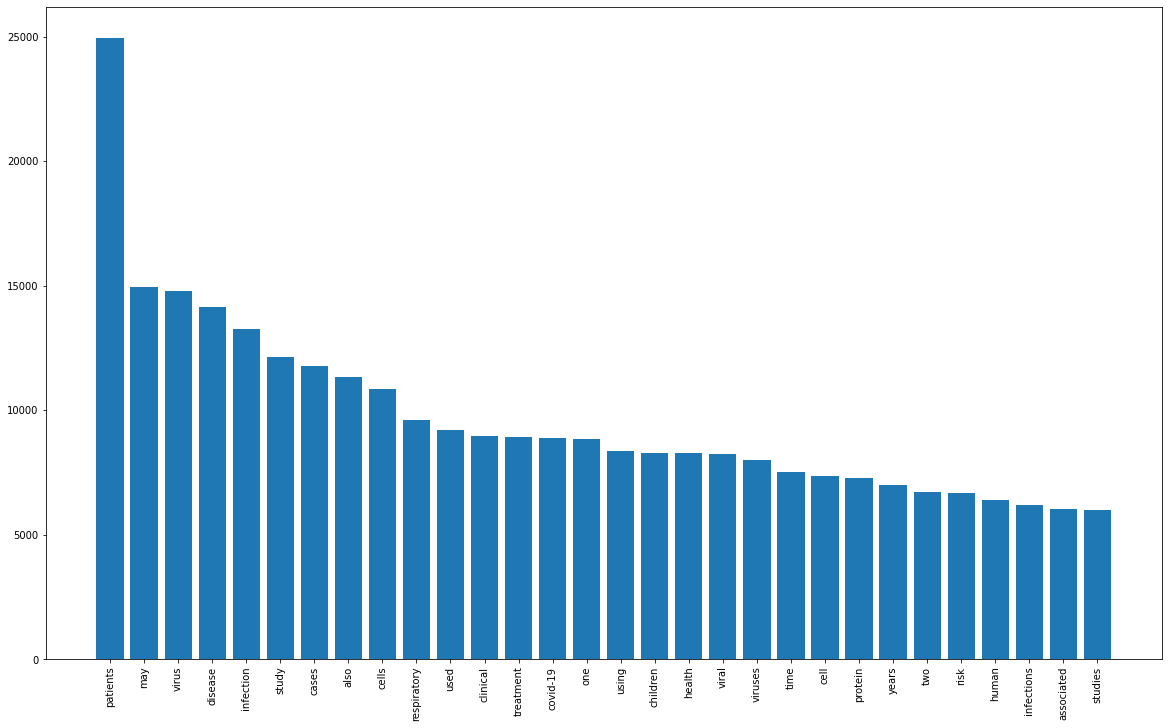

In [ ]:
import matplotlib.pyplot as plt

X = [ x for x,y in fdist1.most_common(30)]
Y = [ y for x,y in fdist1.most_common(30)]

width = 20
height = 12
plt.figure(figsize=(width, height))
plt.xticks(rotation=90)
plt.bar(X,Y)

# Bigrams 

In [ ]:
tokenizer = RegexpTokenizer(r'(\w+)')
tokens_with_stopwords = tokenizer.tokenize(TEXT_CORPUS)
tokens = [i.lower() for i in tokens_with_stopwords if not i.lower() in stop_words]
#print (tokens)

In [ ]:
## Words frequency 

fdist1 = nltk.FreqDist(tokens)
bgs = nltk.bigrams(tokens)
fdist = nltk.FreqDist(bgs)
fdist.most_common(10)

[(('covid', '19'), 9506),
 (('sars', 'cov'), 5969),
 (('cov', '2'), 3252),
 (('public', 'health'), 2180),
 (('2019', 'ncov'), 2090),
 (('mers', 'cov'), 1632),
 (('multiple', 'sclerosis'), 1618),
 (('health', 'care'), 1604),
 (('acute', 'respiratory'), 1575),
 (('respiratory', 'tract'), 1495)]

<BarContainer object of 30 artists>

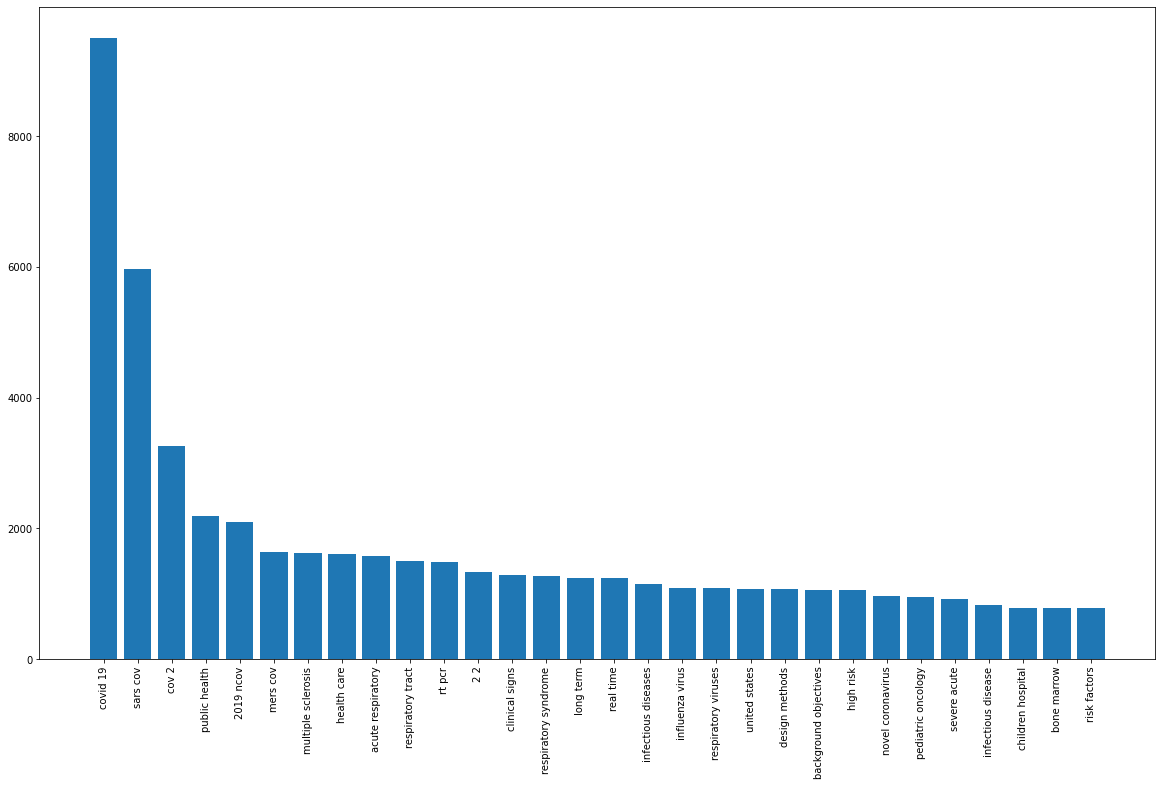

In [ ]:
import matplotlib.pyplot as plt

X = [ x[0] + ' ' +x[1] for x,y in fdist.most_common(30)]
Y = [ y for x,y in fdist.most_common(30)]

width = 20
height = 12
plt.figure(figsize=(width, height))
plt.xticks(rotation=90)
plt.bar(X,Y)

# Trigrams



In [ ]:
tgs = nltk.trigrams(tokens)
fdist = nltk.FreqDist(tgs)
fdist.most_common(10)


[(('sars', 'cov', '2'), 3238),
 (('severe', 'acute', 'respiratory'), 885),
 (('acute', 'respiratory', 'syndrome'), 837),
 (('respiratory', 'syndrome', 'coronavirus'), 546),
 (('patients', 'covid', '19'), 542),
 (('world', 'health', 'organization'), 508),
 (('central', 'nervous', 'system'), 505),
 (('lower', 'respiratory', 'tract'), 498),
 (('covid', '19', 'pandemic'), 492),
 (('polymerase', 'chain', 'reaction'), 471)]

<BarContainer object of 30 artists>

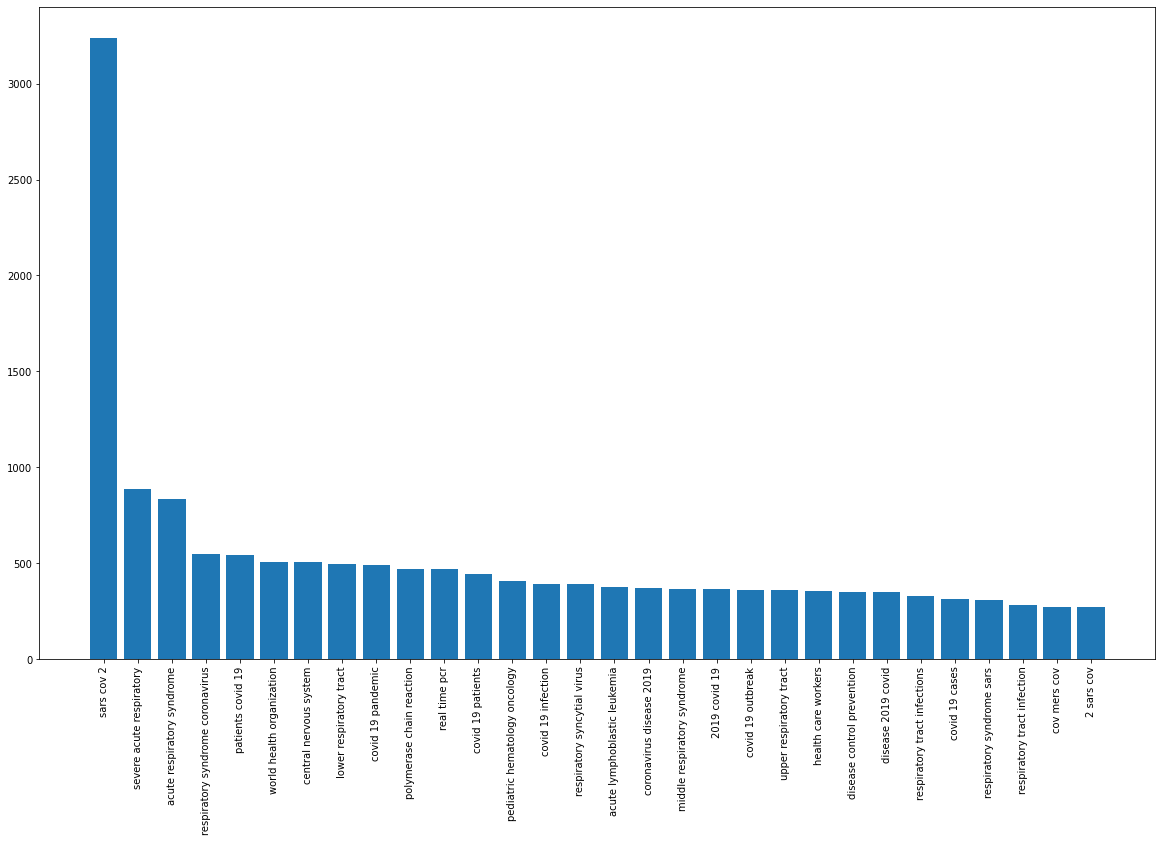

In [ ]:
import matplotlib.pyplot as plt

X = [ x[0] + ' ' +x[1] + ' ' +x[2]  for x,y in fdist.most_common(30)]
Y = [ y for x,y in fdist.most_common(30)]

width = 20
height = 12
plt.figure(figsize=(width, height))
plt.xticks(rotation=90)
plt.bar(X,Y)